<a href="https://colab.research.google.com/github/hudsonmendes/cm3070-fp/blob/objective_1/exps/objective_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Code & Data

In this section, we load the code and the data locally, so that we can utilise  the `hlm12erc` package and use the ml pipelines as they have been designed.

The code files are copied from the following folder, and it's copied to the root directory of the present runtime.
> `/content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp/*`

The following .zip file contains the data compressed, and we decompress it into the `./data` folder:
> `/content/drive/MyDrive/Datasets/meld-transformed.zip`

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
if not os.path.exists("./pyproject.toml"):
  !rm -rf ./src
  !rm -rf ./tests
  !rm -rf ./targets
  !rm -rf ./configs
  !cp -R /content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp/* .
  print("Source Code: overwritten!")

if not os.path.exists("./data/"):
  !unzip -j "/content/drive/MyDrive/Datasets/meld-transformed.zip" -d "./data/"
  print("Data: overwritten!")

In [ ]:
!rm -rf ./data/*.csv
!unzip -j "/content/drive/MyDrive/Datasets/meld-transformerd-csvs.zip" -d "./data/"

# Environment

In this section of our project, we delve into the technical groundwork, outlining the structuring of our dependencies, initializing key system configurations and paths that will be leveraged throughout the ensuing stages.

At the heart of this setup is the setup.cfg file, which lists our project's dependencies and facilitates the seamless installation of our custom-built **`hlm12erc`** library. By using the `-e` option for pip, we unlock dynamic editing capabilities for the library's codebase without requiring repeated reinstallation.

To optimise our system, we've crafted different sets of dependencies for each critical task, including `etl`, `eda`, `modelling`, `training`, and `serving`, allowing us to avoid redundant installations in environments where certain packages aren't needed. We also establish specific log levels and configure Jupyter's `auto-reload` mechanisms, empowering us with real-time updates and valuable debugging insights.

## Dependencies

In [ ]:
!cat ./pyproject.toml

In [ ]:
%pip install -e '.[training]'

**Attention:** for the first time you run this notebook in a runtime, you you must restart your kernel at this point, because the dependencies you installed above bring in newer versions of libraries like `pandas`,etc.

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
%load_ext autoreload
%autoreload 2

## Logging

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Paths & Locations

In [ ]:
import pathlib

# now that the chdir is set to the parent directory of the notebook,
# we can work as if we were running in the root directory of the repository
dir_home = pathlib.Path("./")
dir_data = dir_home / "data"
dir_target = dir_home / "target"
dir_configs = dir_home / "configs"

## GPUs for Training

For this MLOps Pipeline, we use GPUs to accelerate Machine Learning Training.

TPUs have been tried out, but the limitations and constraints related to the TPU architecture caused it to be inviable to the available timeframe of the project. [The main blocker has been reported](https://discuss.pytorch.org/t/error-when-attempting-to-access-xla-tensor-shape/186214) to the PyTorch XLA team before the decision to pivot into GPUs was made.

In [ ]:
# In order to try training using TPUs, uncomment the code below
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

# The following code sets the `device` to one of the GPUs
import torch
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda:0")
device

device(type='cuda', index=0)

# Defining the Problem

Emotion Recognition in Conversations (ERC) refers to the process of recognising and analysing emotions in interactive dialogues. It presents a unique set of challenges given the fact that the same words or phrases could convey different emotions depending on the context and flow of the conversation. This task is further complicated when applied in non-dyadic settings, where multiple participants engage in a dialogue. This makes ERC a complex problem within the realm of machine learning and artificial intelligence, where context modelling and emotional shifts among interlocutors are difficult to address accurately.

Despite its complexity, ERC has garnered significant interest owing to its vast applications in opinion mining over social media threads, chat history, and other online platforms. The ability to accurately discern emotions in conversations can have profound implications for various industries, making any advancements in this field potentially groundbreaking. However, given the sparsity of the solution space and the high variability in model architecture, ERC remains a largely unexplored area with many potential paths for future research and experimentation.

## Multi-Party Setting Challenge

Multi-party conversations present an inherent set of challenges when it comes to emotion recognition (ERC). In a dialogue involving multiple participants, the context, conversation flow, and emotional shifts become considerably more intricate to decipher. The utterances in multi-party dialogues can express a wide range of emotions based on the context, making the task of accurate emotion recognition more arduous. This problem of contextual modelling and accounting for emotion shifts among multiple interlocutors remains a significant challenge in ERC. Additionally, the complex dynamics of multi-party conversations and the interdependence of individual emotional states further complicate the task.

The multi-modality of ERC data also poses another layer of challenge in multi-party settings. As emotions can only be detected through human actions such as textual utterances, visual gestures, and acoustic signals in the absence of physiological indications, the need for effectively dealing with multi-modal data becomes crucial. While some models focus on exploring this multi-modality, others resort to using a single modality, usually textual, thereby ignoring valuable insights that could be gleaned from other modalities. Consequently, the architectural variations in the existing models, coupled with the largely unexplored solution space, underscore the daunting challenges of emotion recognition in multi-party settings.

## Multi-modality Challenge

The multifaceted challenge of Emotion Recognition in Conversations (ERC) is magnified by the multi-modal nature of the data involved. ERC data typically consists of multiple modalities, such as textual utterances, visual cues, and acoustic signals. Accurately detecting emotions from these varied sources is complex, as they can individually or collectively contribute to the overall emotional context. This complexity is amplified by the high-dimensionality of the data, particularly in video and audio modalities. This high-dimensional data is both difficult to investigate and expensive to compute, posing significant challenges in data handling, processing, and analysis.

Furthermore, the computation and training of multi-modal models are exceptionally resource-intensive. Each modality may require distinct computational approaches and algorithms for processing and analyzing the data, increasing the overall computational load. Training such models also necessitates substantial computational power and time, often leading to increased costs and resource allocation. These factors, combined with the diverse architectures proposed to model ERC, contribute to the intricate and computationally demanding nature of emotion recognition. Despite the high costs and complexity, the vast potential applications of accurate ERC underscore the importance of ongoing research in this challenging, yet highly rewarding, field of machine learning.

# Assembling the Dataset

This notebook works on the **Loaded** data (already transformed through the ETL process), and unzipped in the top section of the notebook.

Here is more information about the ETL process used from the `dev/modelling.ipynb`:
> This section of the document focuses on assembling the final dataset that will be used for training and evaluating machine learning models. This involves performing ETL (Extract, Transform, Load) operations on the raw MELD data[1, 2] to prepare it for modelling. ETL is a process used to extract data from various sources, transform it into a format that is suitable for analysis, and load it into a target database or data warehouse. In this section, the raw data is extracted from various sources, transformed into a format that can be used for modelling, and loaded into a Pandas DataFrame.
>
> Here the final dataset is assembled by combining the preprocessed text, audio, and visual features for each example. The `hlm12erc` library is used to load the preprocessed features for each example and combine them into a single DataFrame. This library was created specifically for this project to simplify the notebook code by abstracting the ETL complexity into a simple, well-tested library that could be reused and scheduled if needed. The library was designed with full unit-test coverage to ensure that the data is loaded and combined correctly. The resulting DataFrame contains the preprocessed features for each example, as well as the corresponding label, which will be used for training and evaluating the machine learning models.

In [ ]:
from hlm12erc.training import MeldDataset

ds_sample = MeldDataset(dir_data / f"sample.csv")
ds_train  = MeldDataset(dir_data / f"train.csv")
ds_valid  = MeldDataset(dir_data / f"valid.csv")
ds_test   = MeldDataset(dir_data / f"test.csv")

In [ ]:
ds_train.df

,Unnamed: 0,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...,...
9984,9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Rachel,And this is not the only hospital in this city and we have no problem toWhoa!,,,anger
Joey,Oh-oh! So thats the way its gonna be huh? Yeah I can break the rules too yknow!,,,anger
Monica,"Well, this is my sickness!",,,anger
Joey,Ew! What is that? Something exploded!,,,disgust
Joey,"Oh yeah. If you ah, move your hamper, you see what color the tile used to be. Yeah.",,,disgust
Monica,Close? She's got her tongue in his ear.,,,disgust
Rachel,Oh no,,,fear
Ross,"I-I, I have to tell you something.",,,fear
Phoebe,"Umm look, youre coming on a little strong.",,,fear
Ross,"Well, y'know how I'm trying to work things out with Emily.",,,joy

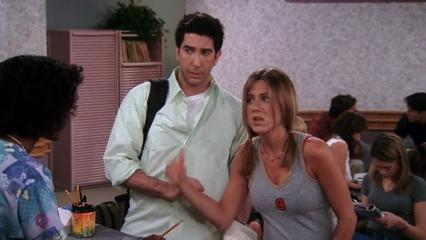
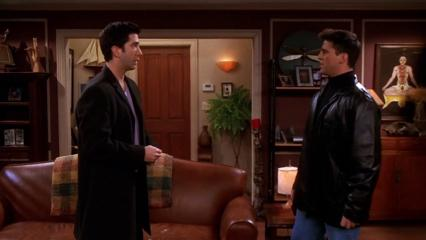
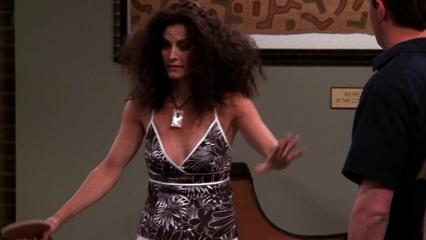
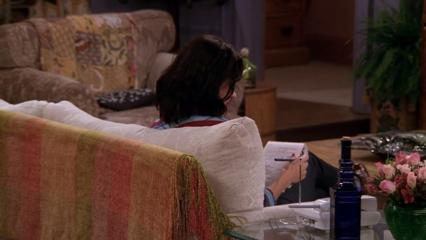
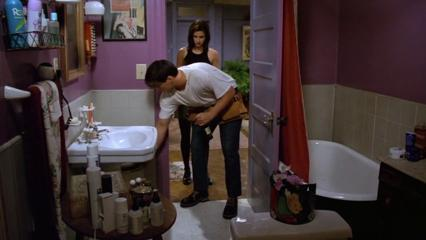
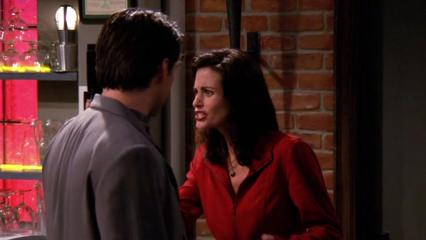
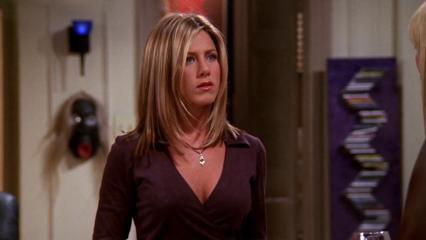
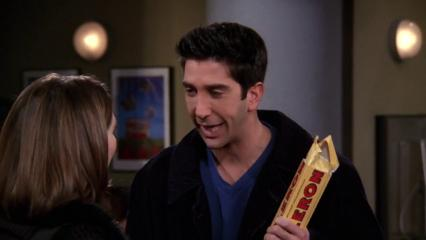
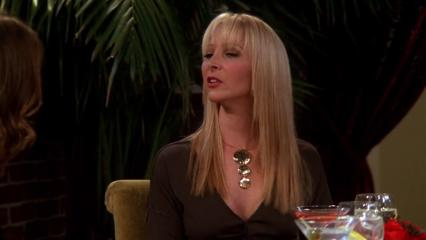
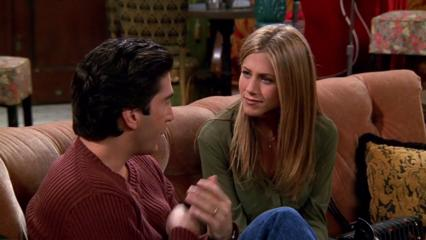
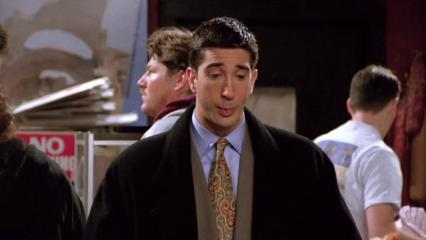
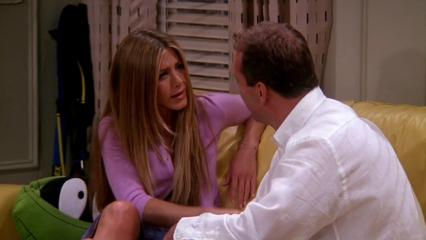
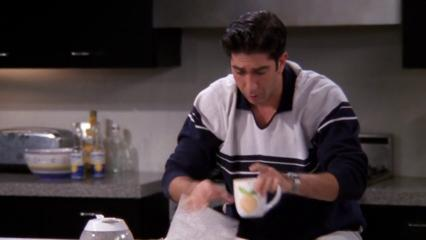
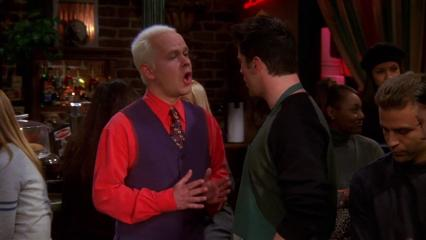
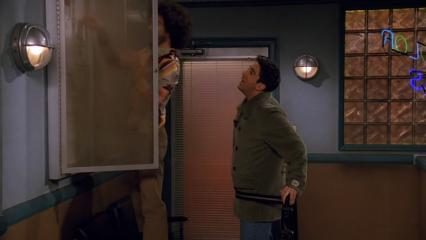
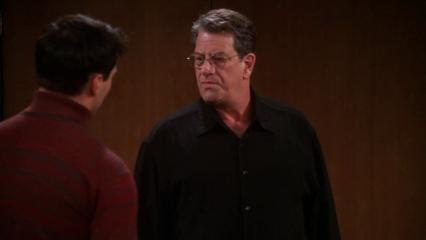
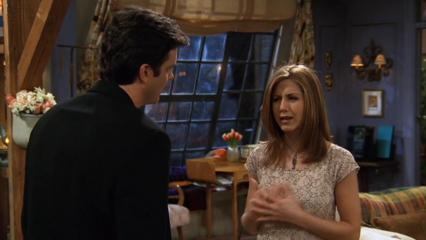
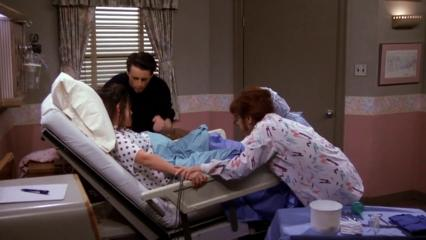
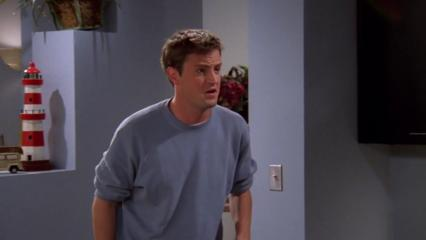
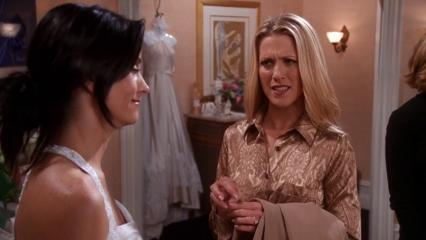
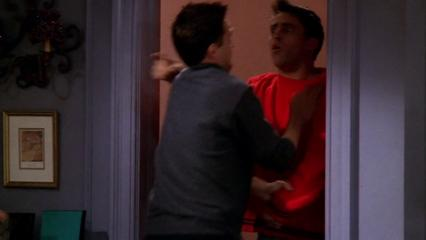

In [ ]:
import os
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = ds_train.df.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{os.path.join("data/", row["x_audio"])}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

# Choosing the Metric of Success

The chosen metric of success for the **HLM12ERC** project, as outlined in the document, is **`Accuracy`**, in the form it's calculated by the `scikit-learn` library[3].

The document establishes the criteria for comparative success between different approaches, such as Advanced Textual Embeddings, based on their ability to achieve superior Accuracy scores over the MELD Test Split. This choice clearly aligns with the principles described by Francois Chollet in "Choosing the Metric of Success"[4], where the selection of a suitable metric is vital for effectively guiding the optimization of machine learning models and for a fair comparative analysis of different methods.

In [ ]:
import inspect
from hlm12erc.training import ERCEvaluator
from IPython.display import Code

class_code = inspect.getsource(ERCEvaluator)
Code(class_code, language="python")

class ERCEvaluator:
    model: ERCModel
    label_encoder: ERCLabelEncoder
    data_collator: ERCDataCollator

    def __init__(self, model: ERCModel) -> None:
        self.model = model
        self.label_encoder = model.label_encoder
        self.data_collator = ERCDataCollator(label_encoder=model.label_encoder, config=model.config)

    def evaluate(
        self,
        dataset: MeldDataset,
        batch_size: int = 4,
        device: torch.device | None = None,
        output_dict: bool = False,
    ) -> Dict[str, Any] | None:
        """
        Evaluates the model on the given dataset.

        :param dataset: The dataset to evaluate on, usually the test split.
        :param batch_size: The size of the batches that will be run against the model
        :param device: The device to run the data collation on
        :param output_dict: Whether to return the classification report dictionary
        :return: The classification report dictionary, unless print_only=True
        """
        if device is not None:
            self.model.to(device)

        emotions = self.label_encoder.classes
        labels, preds = None, None
        with torch.no_grad():
            labels, preds = self._collect_labels_and_preds(dataset, device, batch_size)

        return self._report_on_results(emotions, labels, preds, output_dict)

    def _collect_labels_and_preds(self, dataset, device, batch_size) -> Tuple[List[List[int]], List[List[int]]]:
        """
        Collects the one hot encodings of the true labels and the prediction softmax distributions,
        stack them and run an argmax (on axis 1) to get the integers representing the labels.

        :param dataset: The dataset to evaluate on, usually the test split.
        :param device: The device to run the data collation on
        :param batch_size: The size of the batches that will be run against the model
        :return: A tuple of two lists, the first being the true labels and the second being the predicted labels
        """
        y_true, y_pred = [], []
        for start in trange(0, len(dataset), batch_size, desc="evaluating"):
            end = start + batch_size
            batch_records = dataset[start:end]
            batch_collated = self.data_collator(batch_records, device=device)
            y_true.extend(batch_collated["y_true"])
            y_pred.extend(self.model(**batch_collated).labels)
        labels = torch.stack(y_true, dim=0).argmax(dim=1).tolist()
        preds = torch.stack(y_pred, dim=0).argmax(dim=1).tolist()
        return labels, preds

    def _report_on_results(
        self,
        emotions: List[str],
        labels: List[List[int]],
        preds: List[List[int]],
        output_dict: bool,
    ) -> Dict[str, Any] | None:
        """
        Prints the classification report and returns the report dictionary.

        :param emotions: The list of emotions
        :param labels: The true labels
        :param preds: The predicted labels
        :param output_dict: Whether to return the classification report dictionary
        :return: The classification report dictionary
        """
        print(classification_report(y_true=labels, y_pred=preds, target_names=emotions))
        if output_dict:
            return classification_report(y_true=labels, y_pred=preds, target_names=emotions, output_dict=True)

In [ ]:
import inspect
from hlm12erc.training import ERCMetricCalculator
from IPython.display import Code

class_code = inspect.getsource(ERCMetricCalculator)
Code(class_code, language="python")

class ERCMetricCalculator:
    """
    Responsible for calculating the metrics for an ERC prediction against
    the ground truth, including the loss if a loss function is provided.
    """

    loss_fn: Optional[ERCLoss]

    def __init__(self, classifier_loss_fn: Optional[str] = None) -> None:
        """
        Contructs a new ERCMetricCalculator.

        :param classifier_loss_fn: The name of the loss function to use for the classifier.
        """
        self.loss_fn = None
        if classifier_loss_fn:
            self.loss_fn = ERCLoss.resolve_type_from(classifier_loss_fn)()

    def __call__(self, eval_pred: EvalPrediction) -> Dict[str, Any]:
        """
        Calculates the `acc`, `f1_weighted`, `p_weighted`, `r_weighted`.
        It also produces the `loss` in case a `self.loss_fn` is provided.

        :param eval_pred: The evaluation prediction to calculate the metrics for.
        :return: A dictionary containing the metrics.
        """
        pred, labels = self._extract_pred_loss(eval_pred)
        return self._build_output(
            loss=self._determine_loss(pred=pred, labels=labels),
            y_true=labels.argmax(dim=1).cpu(),
            y_pred=pred.argmax(dim=1).cpu(),
        )

    def _extract_pred_loss(self, eval_pred) -> Tuple[torch.Tensor, torch.Tensor]:
        pred = eval_pred.predictions
        labels = eval_pred.label_ids
        pred = pred[0] if isinstance(pred, tuple) else pred
        pred = torch.from_numpy(pred) if isinstance(pred, np.ndarray) else pred
        labels = torch.from_numpy(labels) if isinstance(labels, np.ndarray) else labels
        return pred, labels

    def _determine_loss(self, pred: torch.Tensor, labels: torch.Tensor):
        return self.loss_fn(y_pred=pred, y_true=labels) if self.loss_fn is not None else None

    def _build_output(self, loss: Union[float, torch.Tensor], y_true: torch.Tensor, y_pred: torch.Tensor):
        output = {}
        if loss:
            output["loss"] = loss.item() if isinstance(loss, torch.Tensor) else loss
        output["acc"] = accuracy_score(y_true, y_pred)
        output["f1_weighted"] = f1_score(y_true, y_pred, average="weighted")
        return output

# Deciding on the Evaluation Protocol

The evaluation protocol for the **HLM12ERC** project adopts the **`Hold Out Test-set`** approach, a decision influenced by the structure of the MELD Dataset and the constraints imposed by its size and multimodal nature. This dataset comes pre-divided into three splits: `train`, `dev`, and `test`, which directly supports the implementation of the Hold Out approach.

The choice of this protocol is further justified due to the impracticability of using methods like K-Fold Cross Validation, stemming from the significant computational demands of the MELD dataset. In addition, the Hold Out Test-set approach serves as the evaluation standard for both individual components (Objectives 1 to 6) and the final model (Objective 7), ensuring consistent assessment throughout the development process.


In [ ]:
import pandas as pd

df_stats = pd.DataFrame.from_dict(
    dict(train=len(ds_train),
         valid=len(ds_valid),
         test=len(ds_test)),
    orient="index",
    columns=["count"])

df_stats["percentage"] = df_stats.apply(
    lambda row: f'{round(100. * row["count"] / df_stats["count"].sum())}%',
    axis=1)

df_stats

,count,percentage
train,9989,73%
valid,1109,8%
test,2610,19%


# Preparing your Data

The data preparation process in this code involves three main stages: (a) ETL (Extract, Transform, Load), (b) DataSet Loading, and (c) Data Collation for model training.

* **ETL:** This stage simplifies the dataset by extracting the data from a Kaggle source, transforming it into a 1st Normal Form (1NF) CSV table format, and loading it into a destination folder or Google Cloud Storage bucket. The ETL process makes the data easier to consume by the training process. The logic can be found in the `hlm12erc.etl` module, and it can also be run with a command-line instruction, and orchestrated through the `hlm12erc.etl.ETL` class.

* **DataSet Loading:** This stage wraps the data using PyTorch Data Utility Classes to shape it appropriately for consumption by the model trainer. This step ensures that the data is organized and can be efficiently fed into the training process. The dataset class is defined at `hlm12erc.training.MeldDataset`.

* **Data Collation:** The Data Collator is responsible for creating batches of data suitable for model training and evaluation. It takes a list of MeldRecord instances and collates the data into a dictionary format with keys like `x_text`, `x_visual`, `x_audio`, and `y_true`. The collation involves converting text, visual, and audio data into appropriate formats and encoding the labels using ERCLabelEncoder, making the data ready for consumption by the PyTorch model's "forward" method during both training and inference. The collator class is defined at `hlm12erc.training.ERCDataCollator`, and can be observed below.

In [ ]:
import inspect
from hlm12erc.training import MeldDataset
from IPython.display import Code

class_code = inspect.getsource(MeldDataset)
Code(class_code, language="python")

class MeldDataset(Dataset):
    """
    Using a dataframe to the dataset .csv file, this class allows access to
    the data in the high level form of a `MeldRecord` object, that already
    carries the visual features (PIL.Image) and audio features (wave.Wave).

    Example:
        >>> df = pd.read_csv("data/meld/train.csv")
        >>> dataset = MeldDataset(df)
        >>> record = dataset[0]
    """

    filepath: pathlib.Path
    filedir: pathlib.Path
    df: pd.DataFrame
    record_reader: MeldRecordReader

    def __init__(self, filepath: pathlib.Path):
        """
        Creates a new instance of the MeldDataset for a split

        :param df: The dataframe containing the data for the split
        """
        self.filepath = filepath
        self.filedir = filepath.parent
        self.df = pd.read_csv(self.filepath).sort_values(by=["dialogue", "sequence"], ascending=[True, True])
        self.record_reader = MeldRecordReader(df=self.df, filename=filepath.stem, filedir=self.filedir)
        self.emotions = sorted(self.df.label.unique().tolist())

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset, based on the length
        of the dataframe itself.

        :return: The number of samples in the dataset
        """
        return len(self.df)

    def __getitem__(self, index: slice | int) -> MeldRecord | List[MeldRecord]:
        """
        Returns a single sample from the dataset, based on the index provided.
        The sample is returned in the form of a `MeldRecord` object, that
        already carries the visual features (PIL.Image) and audio features
        (wave.Wave)

        :param index: The index of the sample to be returned, integer or slice
        :return: A `MeldRecord` instance or batch, containing the sample(s)
        """
        if isinstance(index, slice):
            records = [self.record_reader.read_at(i) for i in range(index.start, index.stop, index.step or 1)]
            return [r for r in records if r is not None]
        elif isinstance(index, int):
            record = self.record_reader.read_at(index)
            if record is None:
                raise IndexError(f"The index '{index}' is out of bounds.")
            return record
        else:
            raise TypeError(f"The index '{index}' is an invalid index type.")

    @property
    def classes(self) -> List[str]:
        """
        Returns a list of the classes in the dataset, based on the unique
        labels in the dataframe.

        :return: A list of the classes in the dataset
        """
        return self.emotions

In [ ]:
import inspect
from hlm12erc.training import ERCDataCollator
from IPython.display import Code

class_code = inspect.getsource(ERCDataCollator)
Code(class_code, language="python")

class ERCDataCollator:
    """
    Collates the data from the ERC dataset into a format that can be used and
    batched by the model, with multiple records turned into lists of its underlying
    datapoints.
    """

    LABEL_NAME: str = "y_true"

    config: ERCConfig
    label_encoder: ERCLabelEncoder
    device: torch.device | None

    def __init__(self, config: ERCConfig, label_encoder: ERCLabelEncoder) -> None:
        """
        Initialise the ERCDataCollator class with the given ERCLabelEncoder object.

        :param config: ERCConfig object containing the configuration
        :param label_encoder: ERCLabelEncoder object containing the label encoder
        """
        self.config = config
        self.label_encoder = label_encoder

    def __call__(
        self,
        batch: List[MeldRecord],
        device: torch.device | None = None,
    ) -> dict:
        """
        Collates the data from the ERC dataset into a format that can be used and
        batched by the model, with multiple records turned into lists of its underlying
        datapoints. We also encode the labels to make it easier to use in the model.

        :param record: The list of records to collate
        :param device: if provided, send tensors to device
        :return: The collated data
        """
        x_text = [r.text for r in batch]
        x_visual = self._visual_to_stacked_tensor([r.visual for r in batch])
        x_audio = self._audio_to_stacked_tensor([r.audio for r in batch])
        y_label = self.label_encoder([r.label for r in batch])
        if device is not None:
            x_visual = x_visual.to(device)
            x_audio = x_audio.to(device)
            y_label = y_label.to(device)
        return {
            "x_text": x_text,
            "x_visual": x_visual,
            "x_audio": x_audio,
            ERCDataCollator.LABEL_NAME: y_label,
        }

    def _visual_to_stacked_tensor(self, videos: List[torch.Tensor]) -> torch.Tensor:
        """
        Stack together tensors representing feature vectors of images.

        :param record: The list of individual tensors for visual data
        :return: The collated visual data as a tensor of shape (batch_size, *visual_in_features)
        """
        return torch.stack(videos, dim=0)

    def _audio_to_stacked_tensor(self, audios: List[torch.from_numpy]) -> torch.Tensor:
        """
        Stack together tensors of different sizes by truncating or padding them
        to the `target_size`.

        :param record: The list of individual tensors for audio data
        :return: The collated audio data as a tensor of shape (batch_size, audio_in_features)
        """

        def truncate_or_pad(vec: torch.Tensor, target_size: int) -> torch.Tensor:
            if vec.size(0) > target_size:
                return vec[:target_size]
            elif vec.size(0) < target_size:
                pad_len = target_size - vec.size(0)
                padding = torch.zeros(pad_len, *vec.size()[1:], dtype=vec.dtype)
                return torch.cat([vec, padding], dim=0)
            else:
                return vec

        vecs = [truncate_or_pad(audio, target_size=self.config.audio_in_features) for audio in audios]
        return torch.stack(vecs, dim=0)

# Model Selection

This section takes us from a baseline model to a final model through a rigorous set of experiments set out by the **Project Design** document as objectives.

We initially attempt to establish a baseline model with some basic approaches to the representation of each modality of the data, which serves as a starting point and upon which we shall iterate.

Then, we utilize a two-step process for each different experiment to evaluate whether we can produce a better model than the ones previously devised. First, a "Scaling up" phase aims to develop a model capable of overfitting the data, allowing deeper insights into its learning capacity and identifying areas for improvement. Second, a "Regularizing" phase addresses overfitting concerns through hyperparameter tuning. This iterative optimization ultimately leads to the final model that fulfills the success criteria and delivers superior performance on the MELD Test Split.

## Monitoring (Weights & Biases)

In [ ]:
%env WANDB_NOTEBOOK_NAME=dev/mlops.ipynb
%env WANDB_PROJECT=hlm12erc

env: WANDB_NOTEBOOK_NAME=dev/mlops.ipynb
env: WANDB_PROJECT=hlm12erc


In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


True

## Training & Evaluation Helpers

In [ ]:
from typing import Tuple
from hlm12erc.modelling import ERCConfigLoader, ERCModel
from hlm12erc.training import ERCTrainer, MeldDataset

def train_model(
    config_name: str,
    datasets: Tuple[MeldDataset, MeldDataset],
    n_epochs: int,
  ) -> Tuple[str, ERCModel]:
  model_config = ERCConfigLoader(dir_configs / f"{config_name}.yml").load()
  model_trainer = ERCTrainer(model_config)
  _, model_instance = model_trainer.train(
      data=datasets,
      n_epochs=n_epochs,
      batch_size=32,
      save_to=(dir_target),
      device=device)
  return model_instance

In [ ]:
from hlm12erc.modelling import ERCModel
from hlm12erc.training import ERCEvaluator, MeldDataset

def evaluate_model(model_instance: ERCModel, dataset: MeldDataset):
  model_evaluator = ERCEvaluator(model_instance)
  model_evaluator.evaluate(
      dataset=dataset,
      batch_size=32,
      device=device)

## Objective 0: Mock Training

In [ ]:
mock_instance = train_model("mock", datasets=(ds_sample, ds_sample), n_epochs=1)
evaluate_model(mock_instance)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,1.507782,1.400839,0.190476,0.060952


eval/acc,▁
eval/f1_weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/acc,▁▁
train/epoch,▁███
train/f1_weighted,▁▁
train/global_step,▁███
train/loss,▁█


evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        fear       0.00      0.00      0.00         2
     neutral       0.00      0.00      0.00        14
     sadness       0.00      0.00      0.00         1
    surprise       0.19      1.00      0.32         4

    accuracy                           0.19        21
   macro avg       0.05      0.25      0.08        21
weighted avg       0.04      0.19      0.06        21



## Objective 1: Baseline Model

In [ ]:
baseline_instance = train_model("baseline", datasets=(ds_train, ds_valid), n_epochs=10)
evaluate_model(baseline_instance, dataset=ds_test)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,1.895749,1.833325,0.423805,0.252297
2,1.740506,1.742728,0.423805,0.252297
3,1.737829,1.741933,0.423805,0.252297
4,1.737346,1.741780,0.423805,0.252297
5,1.737174,1.741723,0.423805,0.252297
6,1.737091,1.741695,0.423805,0.252297
7,1.737046,1.741680,0.423805,0.252297
8,1.737022,1.741671,0.423805,0.252297
9,1.737010,1.741667,0.423805,0.252297
10,1.737006,1.741665,0.423805,0.252297


eval/acc,▁▁▁▁▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁▁▁▁▁
eval/loss,█▁▁▁▁▁▁▁▁▁
eval/runtime,▆▇█▂▂▆▁▂▁▂
eval/samples_per_second,▂▂▁▆▇▃█▇█▇
eval/steps_per_second,▂▂▁▆▇▃█▇█▇
train/acc,▁▁▄▃▃▆▇▅▅▆▅▅▄▆▆▅▆▆▅▅▇▆▅▆▆▇▆▆▄▅▆▇▆▆▅▄▆▃█▄
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▁▅▄▄▇▇▅▅▆▅▅▅▆▆▅▆▆▅▆▇▆▅▆▆▇▇▆▅▆▆▇▆▆▅▅▆▄█▅
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: ignored

evaluating:   0%|          | 0/82 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.00      0.00      0.00       402
     neutral       0.48      1.00      0.65      1256
     sadness       0.00      0.00      0.00       208
    surprise       0.00      0.00      0.00       281

    accuracy                           0.48      2610
   macro avg       0.07      0.14      0.09      2610
weighted avg       0.23      0.48      0.31      2610

